In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to directories
path = '/content/drive/MyDrive/TFM - Neural ODEs/Neural ODE/df.csv'

# Read data
date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
df = pd.read_csv(path, sep=',', index_col='datetime', parse_dates=['datetime'], date_parser=date_parser)
df.head()

Mounted at /content/drive


<ipython-input-2-f9765ec2bc53>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  date_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')


,demand,wind,price,day_of_week
datetime,,,,
2018-01-01 00:00:00,22718.1,11487.7,6.74,7
2018-01-01 01:00:00,21510.8,10123.2,4.74,7
2018-01-01 02:00:00,19865.8,8763.5,3.66,7
2018-01-01 03:00:00,19248.3,5661.2,2.30,7
2018-01-01 04:00:00,18632.1,5689.0,2.30,7


In [ ]:
df = df[['price']]
df

,price
datetime,
2018-01-01 00:00:00,6.74
2018-01-01 01:00:00,4.74
2018-01-01 02:00:00,3.66
2018-01-01 03:00:00,2.30
2018-01-01 04:00:00,2.30
...,...
2022-12-31 19:00:00,18.11
2022-12-31 20:00:00,7.60
2022-12-31 21:00:00,3.69


In [ ]:
# Training set. From Wednesday to Wednesday: 14 months
train_df = df.loc['2018-03-07 00:00':'2019-04-24 23:00']
train_spot = train_df.values
train_df

,price
datetime,
2018-03-07 00:00:00,41.83
2018-03-07 01:00:00,39.80
2018-03-07 02:00:00,37.81
2018-03-07 03:00:00,37.61
2018-03-07 04:00:00,37.54
...,...
2019-04-24 19:00:00,39.45
2019-04-24 20:00:00,42.08
2019-04-24 21:00:00,49.59


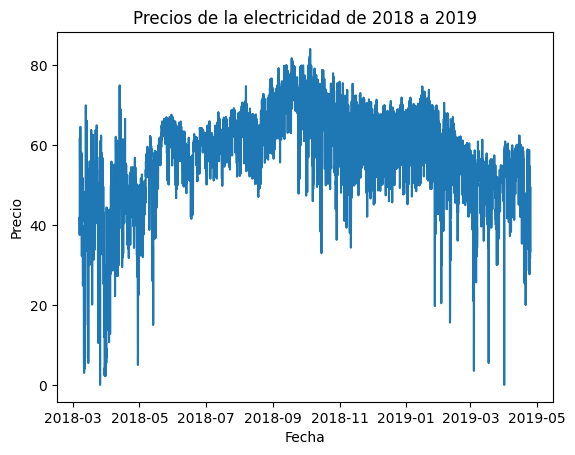

In [ ]:
import matplotlib.pyplot as plt

# Crear una figura y un eje
fig, ax = plt.subplots()

# Graficar los datos
ax.plot(train_df.index, train_df['price'])

# Añadir título y etiquetas
ax.set_title('Precios de la electricidad de 2018 a 2019')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio')

# Mostrar la gráfica
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


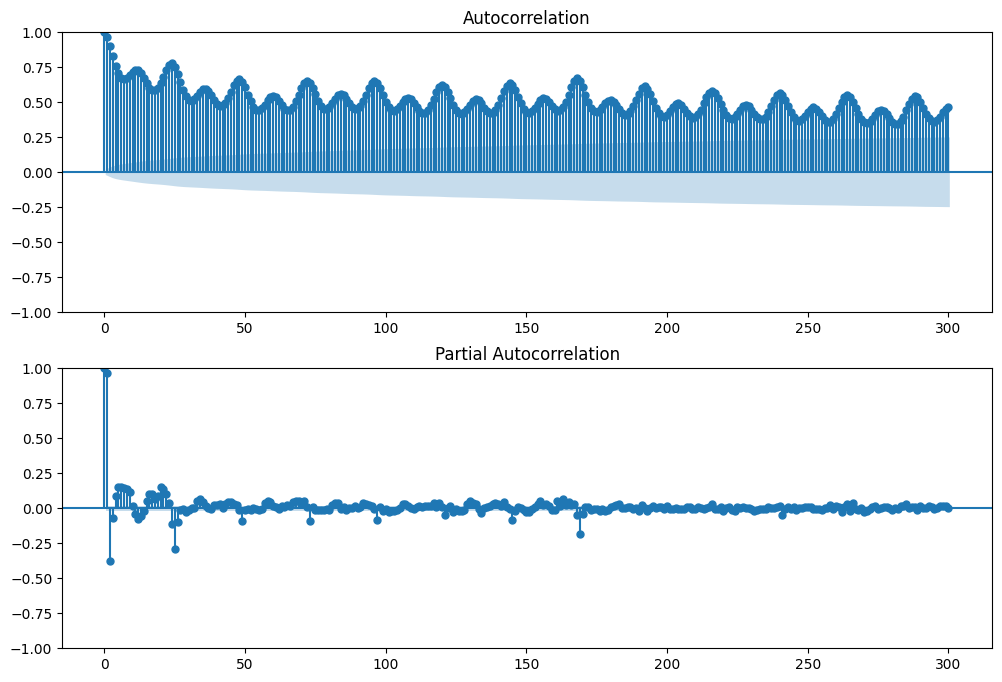

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Time series: ACF and PACF
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# for 'price'
plot_acf(train_df, lags=300, ax=axs[0])
plot_pacf(train_df, lags=300, ax=axs[1])

plt.show()

In [ ]:
# Validation set: 3 months
validation_df = df.loc['2019-05-01 00:00':'2019-07-31 23:00']
validation_spot = validation_df.values
validation_df

,price
datetime,
2019-05-01 00:00:00,57.63
2019-05-01 01:00:00,56.56
2019-05-01 02:00:00,55.52
2019-05-01 03:00:00,55.71
2019-05-01 04:00:00,55.00
...,...
2019-07-31 19:00:00,48.79
2019-07-31 20:00:00,48.17
2019-07-31 21:00:00,48.79


In [ ]:
# Test set: 3 months
test_df = df.loc['2019-08-07 00:00':'2019-10-30 23:00']
test_spot = test_df.values
test_df

,price
datetime,
2019-08-07 00:00:00,49.76
2019-08-07 01:00:00,46.21
2019-08-07 02:00:00,43.51
2019-08-07 03:00:00,41.75
2019-08-07 04:00:00,42.80
...,...
2019-10-30 19:00:00,60.00
2019-10-30 20:00:00,56.85
2019-10-30 21:00:00,55.50


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Declaration of the scaler
scaler_price = MinMaxScaler(feature_range=(0, 1))

# Scaler is fitted with the training data
scaler_price.fit(train_df[["price"]])

# Applying scaler to the 'price' column for each set
train_df.loc[:, "price"] = scaler_price.transform(train_df[["price"]])
validation_df.loc[:, "price"] = scaler_price.transform(validation_df[["price"]])
test_df.loc[:, "price"] = scaler_price.transform(test_df[["price"]])

<ipython-input-9-7fe8e00f35ca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, "price"] = scaler_price.transform(train_df[["price"]])
<ipython-input-9-7fe8e00f35ca>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df.loc[:, "price"] = scaler_price.transform(validation_df[["price"]])
<ipython-input-9-7fe8e00f35ca>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [ ]:
def create_windows(df, window_size=168, forecast_size=24):
    input_data, output_data = [], []

    # Step through the dataframe with a step size of 168 (7*24)
    for i in range(window_size, len(df) - forecast_size + 1, window_size):
        inputs = df.iloc[i-window_size:i]["price"].values
        outputs = df.iloc[i:i+forecast_size]["price"].values
        input_data.append(inputs)
        output_data.append(outputs)

    return np.array(input_data), np.array(output_data)

window_size = 168
forecast_size = 24

X_train, Y_train = create_windows(train_df, window_size, forecast_size)
X_validation, Y_validation = create_windows(validation_df, window_size, forecast_size)
X_test, Y_test = create_windows(test_df, window_size, forecast_size)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
X_train.shape

(59, 168, 1)

In [ ]:
Y_train.shape

(59, 24)

In [ ]:
X_validation.shape

(13, 168, 1)

In [ ]:
X_test.shape

(12, 168, 1)

In [ ]:
# Model declaration
LSTM_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(500, return_sequences=True, input_shape=(window_size, 1)),
    tf.keras.layers.LSTM(500),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(forecast_size)
])


LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 500)          1004000   
                                                                 
 lstm_1 (LSTM)               (None, 500)               2002000   
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense (Dense)               (None, 24)                12024     
                                                                 
Total params: 3,018,024
Trainable params: 3,018,024
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.model.reset_states()

In [ ]:
initial_learning_rate = 0.1
final_learning_rate = 0.01
num_epochs = 2000  # number of epochs

def scheduler(epoch, lr):
    if epoch < num_epochs:
        return initial_learning_rate - ((initial_learning_rate - final_learning_rate) * (epoch / num_epochs))
    else:
        return final_learning_rate

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

lr_schedule = LearningRateScheduler(scheduler)

In [ ]:
loss = tf.keras.losses.MeanAbsoluteError()
reset_states = ResetStatesCallback()
optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate, momentum=0.8)

LSTM_model.compile(optimizer=optimizer, loss=loss, metrics='mae')
save_model = ModelCheckpoint("LSTM_model.h5", monitor='val_loss', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=300, monitor='val_loss')

history = LSTM_model.fit(
    X_train, Y_train,
    validation_data=(X_validation, Y_validation),
    epochs=num_epochs,
    callbacks=[save_model, reset_states, early_stopping, lr_schedule]
)

Epoch 1/2000
2/2 [==============================] - 10s 878ms/step - loss: 0.6891 - mae: 0.6891 - val_loss: 0.5328 - val_mae: 0.5328 - lr: 0.1000
Epoch 2/2000
2/2 [==============================] - 0s 134ms/step - loss: 0.6120 - mae: 0.6120 - val_loss: 0.4088 - val_mae: 0.4088 - lr: 0.1000
Epoch 3/2000
2/2 [==============================] - 0s 232ms/step - loss: 0.4580 - mae: 0.4580 - val_loss: 0.1678 - val_mae: 0.1678 - lr: 0.0999
Epoch 4/2000
2/2 [==============================] - 0s 87ms/step - loss: 0.1979 - mae: 0.1979 - val_loss: 0.3070 - val_mae: 0.3070 - lr: 0.0999
Epoch 5/2000
2/2 [==============================] - 0s 131ms/step - loss: 0.1981 - mae: 0.1981 - val_loss: 0.0866 - val_mae: 0.0866 - lr: 0.0998
Epoch 6/2000
2/2 [==============================] - 0s 120ms/step - loss: 0.1502 - mae: 0.1502 - val_loss: 0.0785 - val_mae: 0.0785 - lr: 0.0998
Epoch 7/2000
2/2 [==============================] - 0s 69ms/step - loss: 0.1454 - mae: 0.1454 - val_loss: 0.1249 - val_mae: 0.1249

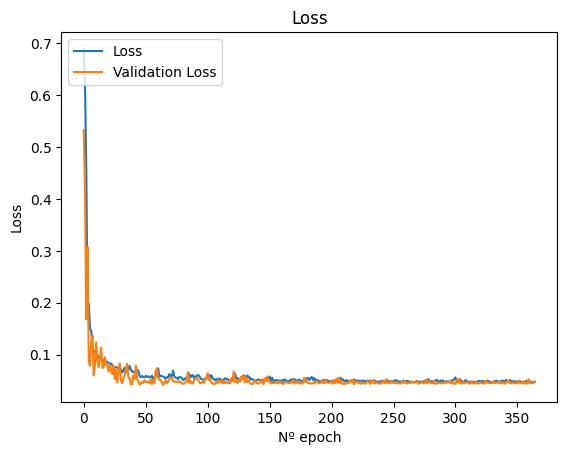

In [ ]:
# Loss history
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Nº epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Loading the best model
LSTM_model = tf.keras.models.load_model('LSTM_model.h5')

# Forecasting the next 24h per window
test_predictions = LSTM_model.predict(X_test)

1/1 [==============================] - 1s 687ms/step


In [ ]:
# Scaling back the forecasts and actual values
predictions = scaler_price.inverse_transform(test_predictions)
y_test = scaler_price.inverse_transform(Y_test.squeeze())

In [ ]:
# Test loss
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("MSE: ", mse)
print("MAE: ", mae)

MSE:  17.03673576373367
MAE:  3.178693454265595


In [ ]:
# Histogram of residuals
def residual_histogram(y_true, y_pred, step):
    # copy of the input lists
    true = y_true[:]
    pred = y_pred[:]
    # empty list to allocate residuals
    residual = []
    if len(true) ==len(pred):
        for cicle in range(len(true)):
            for item in range(len(true[cicle])):
                residual.append(true[cicle][item] - pred[cicle][item])

    minim = min(residual)
    maxim = max(residual)

    bins = int(abs((maxim - minim) / step))

    df = pd.DataFrame(residual)
    hist = df.hist(bins = bins)
    return residual

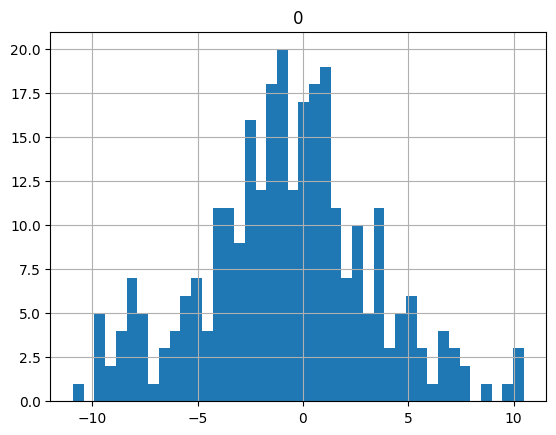

In [ ]:
residuals = residual_histogram(y_test, predictions, 0.5)